# CRM Sales Data Processing Pipeline

This notebook mimics the data processing functionality of the ingestion pipeline, working directly with data from the `./data` folder. It performs data loading, validation, preprocessing, and feature engineering for CRM sales opportunities.

**Target**: Predict `deal_stage` outcomes for sales opportunities

## 1. Import Required Libraries

Import pandas, numpy, and other necessary libraries for data processing.

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
import kaggle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random

warnings.filterwarnings('ignore')

# Set up pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Load Data from Files

Load CRM data files from the `./data/raw` folder using pandas.

In [257]:
# Define data paths
data_dir = Path("../data_temp")
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"
features_dir = data_dir / "features"

In [258]:
refresh_from_source = False

if refresh_from_source:
    # Download and extract the dataset
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        'innocentmfa/crm-sales-opportunities',
        path=raw_dir,
        unzip=True
    )

In [259]:
# Load main sales pipeline data
df_sales = pd.read_csv(raw_dir / "sales_pipeline.csv")

print(f"Data Shape: {df_sales.shape}")
print(f"Columns: {list(df_sales.columns)}")
df_sales.head()

Data Shape: (8800, 8)
Columns: ['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage', 'engage_date', 'close_date', 'close_value']


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0


In [260]:
# Load additional reference data
df_accounts = pd.read_csv(raw_dir / "accounts.csv")
df_products = pd.read_csv(raw_dir / "products.csv")
df_sales_teams = pd.read_csv(raw_dir / "sales_teams.csv")
df_data_dict = pd.read_csv(raw_dir / "data_dictionary.csv")
    
print(f"Accounts Shape: {df_accounts.shape}")
print(f"Products Shape: {df_products.shape}")
print(f"Sales Teams Shape: {df_sales_teams.shape}")
print(f"Data Dictionary Shape: {df_data_dict.shape}")
    

Accounts Shape: (85, 7)
Products Shape: (7, 3)
Sales Teams Shape: (35, 3)
Data Dictionary Shape: (21, 3)


## 3. Enhance Sales Opportunities data for simulation purposes

In [261]:
df_sales1 = df_sales.copy()
# Add opportunity creation date as offset of engagement date
df_sales1['random_number'] = np.random.randint(10, 30, df_sales1.shape[0])
# Create creation date by subtracting a random number of days from the engagement date
df_sales1['creation_date'] = pd.to_datetime(df_sales1['engage_date'], errors='coerce')
# If engage_date is NaN, set creation_date to max of the engagement date
m = pd.to_datetime(df_sales1['engage_date'], errors='coerce').max()
df_sales1['creation_date'] = df_sales1['creation_date'].fillna(m)
df_sales1['creation_date'] = df_sales1['creation_date'] - pd.to_timedelta(df_sales1['random_number'], unit='D')
df_sales1 = df_sales1.drop(columns=['random_number'])
df_sales1[df_sales1['engage_date'].isna()].head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,creation_date
8300,6CWZFOHJ,Anna Snelling,GTX Basic,Green-Plus,Prospecting,NaN,NaN,NaN,2017-12-04
8301,3LCLVRVV,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN,2017-12-14
8302,YIU1B39V,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN,2017-11-29
8303,8E0VRCLW,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN,2017-12-06
8304,G99CS23F,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN,2017-12-17


In [262]:
def _adjust_dates_and_stage(period, group):
    """
    Adjusts the dates and stages in the sales opportunities data.
    """
    # Calculate last date of the period
    last_date = pd.to_datetime(period, errors='coerce').to_period('M').end_time.date()
    # Add last date to the group in date format
    group['snapshot_date'] = last_date
    group.loc[pd.to_datetime(group['close_date'], errors='coerce') > group['snapshot_date'], 'deal_stage'] = 'Engaging'
    group.loc[pd.to_datetime(group['close_date'], errors='coerce') > group['snapshot_date'], 'close_date'] = pd.NaT
    group.loc[pd.to_datetime(group['engage_date'], errors='coerce') > group['snapshot_date'], 'deal_stage'] = 'Prospecting'
    group.loc[pd.to_datetime(group['engage_date'], errors='coerce') > group['snapshot_date'], 'engage_date'] = pd.NaT

    return group

In [ ]:
df_sales2 = df_sales1.copy()

# Remove all monthly files before saving new ones
for file in raw_dir.glob("sales_pipeline_*.csv"):
    file.unlink()
#Add creation year-month
df_sales2['creation_year_month'] = df_sales2['creation_date'].dt.to_period('M')
#Split dataset by creation month and save to CSV
# First months_to_aggregate months will be saved into a single fine, the rest will be saved separately
df_sales2['creation_year_month'] = df_sales2['creation_year_month'].astype(str)
months_to_aggregate = 8
# Save each period's data to a separate CSV file
df_first_group = pd.DataFrame(columns=df_sales2.columns)
group_count = 1
for period, group in df_sales2.groupby('creation_year_month'):
    if group_count < months_to_aggregate:
        df_first_group = pd.concat([df_first_group, group])
    elif group_count == months_to_aggregate:
        df_first_group = pd.concat([df_first_group, group])
        df_first_group = _adjust_dates_and_stage(period, df_first_group)
        # Save the aggregated data to a CSV file
        df_first_group.to_csv(raw_dir / f"sales_pipeline_{period}.csv", index=False)
        print(f"Saved {len(df_first_group)} records for period {period} to CSV.")
    else:
        group = _adjust_dates_and_stage(period, group)
        # Save each group to a separate CSV file
        group.to_csv(raw_dir / f"sales_pipeline_{period}.csv", index=False)
        print(f"Saved {len(group)} records for period {period} to CSV.")
    group_count += 1


Saved 4045 records for period 2017-05 to CSV.
Saved 1002 records for period 2017-06 to CSV.
Saved 1036 records for period 2017-07 to CSV.
Saved 769 records for period 2017-08 to CSV.
Saved 816 records for period 2017-09 to CSV.
Saved 416 records for period 2017-10 to CSV.
Saved 262 records for period 2017-11 to CSV.
Saved 454 records for period 2017-12 to CSV.


## 4. Data Cleaning and Preprocessing

Clean the data by handling missing values, duplicates, and data type conversions.

In [264]:
df_sales = df_first_group.copy()

In [265]:
# Schema validation based on CRM schema requirements

# Required columns check
required_columns = [
    'opportunity_id', 'sales_agent', 'product', 'account', 
    'deal_stage', 'engage_date', 'close_date', 'close_value'
]
missing_columns = set(required_columns) - set(df_sales.columns)
if missing_columns:
    print(f"Missing required columns: {missing_columns}")
# Valid deal stages check
valid_deal_stages = ['Won', 'Lost', 'Engaging', 'Prospecting']
invalid_stages = set(df_sales['deal_stage'].unique()) - set(valid_deal_stages)
if invalid_stages:
    print(f"Invalid deal stages found: {invalid_stages}")
# Close value validation
if df_sales['close_value'].min() < 0:
    print(f"Negative close values found")

In [266]:
# Check data info and missing values
print(f"Shape: {df_sales.shape}")
print(f"Memory usage: {df_sales.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("Missing values:")
missing_summary = df_sales.isnull().sum()
print(missing_summary[missing_summary > 0])

print("Data types:")
print(df_sales.dtypes)

Shape: (4045, 11)
Memory usage: 2.32 MB
Missing values:
account         451
engage_date     472
close_date     2007
close_value     670
dtype: int64
Data types:
opportunity_id                 object
sales_agent                    object
product                        object
account                        object
deal_stage                     object
engage_date                    object
close_date                     object
close_value                   float64
creation_date          datetime64[ns]
creation_year_month            object
snapshot_date                  object
dtype: object


In [267]:
# Check for duplicates
print(f"Total rows: {len(df_sales)}")
duplicates = df_sales.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
df_sales = df_sales.drop_duplicates()
print(f"Total rows after dedup: {len(df_sales)}")

# Check unique values in key columns
print(f"Deal Stages: {df_sales['deal_stage'].value_counts()}")
print(f"Unique Sales Agents: {df_sales['sales_agent'].nunique()}")
print(f"Unique Products: {df_sales['product'].nunique()}")
print(f"Unique Accounts: {df_sales['account'].nunique()}")

Total rows: 4045
Duplicate rows: 0
Total rows after dedup: 4045
Deal Stages: deal_stage
Engaging       1535
Won            1254
Lost            784
Prospecting     472
Name: count, dtype: int64
Unique Sales Agents: 30
Unique Products: 7
Unique Accounts: 85


In [268]:
# Handle missing values
missing_before = df_sales.isnull().sum().sum()    
print(f"Missing values before categorical columns processing: {missing_before}")
# Fill missing categorical values with 'Unknown'
categorical_cols = df_sales.select_dtypes(include=['object']).columns
df_sales1 = df_sales.copy()
df_sales1[categorical_cols] = df_sales1[categorical_cols].fillna('Unknown')
print(f"Filled missing categorical values with 'Unknown' in columns: {list(categorical_cols)}")


# Select deals with stage 'Won' or 'Lost'
missing_before = df_sales1[df_sales1['deal_stage'].isin(['Won', 'Lost'])].isnull().sum().sum()
print("Total rows with 'Won' or 'Lost':", len(df_sales1[df_sales1['deal_stage'].isin(['Won', 'Lost'])]))
print(f"Missing values before numeric columns processing: {missing_before}")

# Fill missing numerical values with median
numerical_cols = df_sales1.select_dtypes(include=['number']).columns
df_sales2 = df_sales1.copy()
for col in numerical_cols:
    if df_sales1[col].isnull().any():
        median_val = df_sales1[df_sales1['deal_stage'].isin(['Won', 'Lost'])][col].median()
        df_sales2[col] = df_sales2[col].fillna(median_val)
        print(f"Filled missing values in {col} with median: {median_val}")

missing_after = df_sales2.isnull().sum().sum()
print(f"Missing values after processing: {missing_after}")

Missing values before categorical columns processing: 3600
Filled missing categorical values with 'Unknown' in columns: ['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage', 'engage_date', 'close_date', 'creation_year_month', 'snapshot_date']
Total rows with 'Won' or 'Lost': 2038
Missing values before numeric columns processing: 0
Filled missing values in close_value with median: 65.5
Missing values after processing: 0


In [269]:
# Convert date columns to datetime
df_sales3 = df_sales2.copy()

print(f"Engage date range: {df_sales3['engage_date'].min()} to {df_sales3['engage_date'].max()}")
print(f"Close date range: {df_sales3['close_date'].min()} to {df_sales3['close_date'].max()}")

# Check missing dates
print(f"Missing engage dates: {df_sales3[df_sales3['deal_stage'].isin(['Won', 'Lost', 'Engaging'])]['engage_date'].isnull().sum()}")
print(f"Missing close dates: {df_sales3[df_sales3['deal_stage'].isin(['Won', 'Lost'])]['close_date'].isnull().sum()}")

Engage date range: 2016-10-20 to Unknown
Close date range: 2017-03-01 to Unknown
Missing engage dates: 0
Missing close dates: 0


In [270]:
# Handle missing close_value (convert to numeric if needed)
df_sales4 = df_sales3.copy()
df_sales4['close_value'] = pd.to_numeric(df_sales4['close_value'], errors='coerce')

print(f"Close value statistics:")
print(df_sales4[df_sales4['deal_stage'].isin(['Won', 'Lost'])]['close_value'].describe())
print(f"Missing close values: {df_sales4['close_value'].isnull().sum()}")

# Fill missing close_value for open deals with 0 (they haven't closed yet)
open_deals_mask = df_sales4['deal_stage'].isin(['Engaging', 'Prospecting'])
df_sales4.loc[open_deals_mask & df_sales4['close_value'].isnull(), 'close_value'] = 0


Close value statistics:
count     2038.000000
mean      1414.287046
std       2164.355517
min          0.000000
25%          0.000000
50%         65.500000
75%       3166.250000
max      25897.000000
Name: close_value, dtype: float64
Missing close values: 0


## 5. Data Transformation

Apply transformations such as filtering, feature creation, and column operations.

### Sales Pipeline

In [271]:
# Close value features
# Log transformation for close value (add 1 to handle 0 values)
df_features = df_sales4.copy()
df_features['close_value_log'] = np.log1p(df_features['close_value'])

# Close value categories
df_features['close_value_category'] = pd.cut(
    df_features['close_value'],
    bins=[0, 1000, 5000, 10000, 50000, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large', 'Enterprise'],
    include_lowest=True
)

print("Close value features created")
print(f"Value categories distribution:")
print(df_features['close_value_category'].value_counts())

Close value features created
Value categories distribution:
close_value_category
Small         2813
Medium         903
Large          317
Very Large      12
Enterprise       0
Name: count, dtype: int64


In [272]:
# Create deal stage features
df_features1 = df_features.copy()
# Create deal stage progression indicator
stage_order = {
    'Prospecting': 1,
    'Engaging': 2,
    'Won': 4,
    'Lost': 0  # Lost deals get 0
}
df_features1['deal_stage_order'] = df_features1['deal_stage'].map(stage_order)

# Create binary features for deal status using 1 and 0
df_features1['is_closed'] = df_features1['deal_stage'].isin(['Won', 'Lost']).astype(int)
df_features1['is_won'] = (df_features1['deal_stage'] == 'Won').astype(int)
df_features1['is_lost'] = (df_features1['deal_stage'] == 'Lost').astype(int)
df_features1['is_open'] = (1 - df_features1['is_closed']).astype(int)

print("Deal stage features created")
print(f"Deal status distribution:")
print(f"   Closed deals: {df_features1['is_closed'].sum()}")
print(f"   Won deals: {df_features1['is_won'].sum()}")
print(f"   Lost deals: {df_features1['is_lost'].sum()}")
print(f"   Open deals: {df_features1['is_open'].sum()}")
df_features1.head()

Deal stage features created
Deal status distribution:
   Closed deals: 2038
   Won deals: 1254
   Lost deals: 784
   Open deals: 2007


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,creation_date,creation_year_month,snapshot_date,close_value_log,close_value_category,deal_stage_order,is_closed,is_won,is_lost,is_open
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,2016-10-10,2016-10,2017-05-31,6.961296,Medium,4,1,1,0,0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,2016-10-11,2016-10,2017-05-31,8.415160,Medium,4,1,1,0,0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,2016-10-06,2016-10,2017-05-31,3.931826,Small,4,1,1,0,0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,2016-10-12,2016-10,2017-05-31,6.378426,Small,4,1,1,0,0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,2016-10-11,2016-10,2017-05-31,6.249975,Small,4,1,1,0,0


### Sales Agent

In [273]:
#Join with Sales Agent
df_features2 = df_features1.copy()
df_features2 = df_features2.merge(
    df_sales_teams,
    on='sales_agent',
    how='left'
)

# Check missing values after join
missing_after_join = df_features2['regional_office'].isnull().sum().sum()
print(f"Missing values after join with sales teams: {missing_after_join}")

Missing values after join with sales teams: 0


In [274]:
# Create sales agent performance features
# Count of opportunities per agent
df_features3 = df_features2.copy()
agent_counts = df_features3['sales_agent'].value_counts()
df_features3['agent_opportunity_count'] = df_features3['sales_agent'].map(agent_counts)

# Agent performance metrics (for closed deals)
agent_performance = df_features3[df_features3['is_closed']==1].groupby('sales_agent').agg({
    'is_won': ['mean', 'sum'],
    'close_value': ['mean', 'sum'],
    'opportunity_id': 'count'
}).round(3)

agent_performance.columns = ['win_rate', 'total_wins', 'avg_deal_value', 'total_revenue', 'closed_deals']
agent_win_rates = agent_performance['win_rate']
df_features3['agent_win_rate'] = df_features3['sales_agent'].map(agent_win_rates)

print(f"Top performing agents (by win rate):")
print(agent_performance.sort_values('win_rate', ascending=False).head())

Top performing agents (by win rate):
                 win_rate  total_wins  avg_deal_value  total_revenue  \
sales_agent                                                            
Maureen Marcano     0.714          50        1696.471       118753.0   
Wilburn Farren      0.684          13        2263.789        43012.0   
Kami Bicknell       0.674          62        1273.761       117186.0   
Cassey Cress        0.667          52        1919.141       149693.0   
Corliss Cosme       0.667          44        1790.530       118175.0   

                 closed_deals  
sales_agent                    
Maureen Marcano            70  
Wilburn Farren             19  
Kami Bicknell              92  
Cassey Cress               78  
Corliss Cosme              66  


### Product

In [275]:
# Create product features
df_features4 = df_features3.copy()
df_features4 = df_features4.merge(
    df_products,
    on='product',
    how='left')

# Check missing values after join
missing_after_join = df_features4['product'].isnull().sum().sum()
if missing_after_join > 0:
    print(f"Missing values after join with products: {missing_after_join}")

# Product popularity
product_counts = df_features4['product'].value_counts()
df_features4['product_popularity'] = df_features4['product'].map(product_counts)
df_features4['product_win_rate'] = df_features4['product'].map(product_counts)

# Product performance
product_performance = df_features4[df_features4['is_closed']==1].groupby('product').agg({
    'is_won': 'mean',
    'close_value': 'mean',
    'opportunity_id': 'count'
}).round(3)

product_performance.columns = ['product_win_rate', 'product_avg_value', 'product_deals_count']
df_sales['product_win_rate'] = df_sales['product'].map(product_performance['product_win_rate'])

print(product_performance.sort_values('product_win_rate', ascending=False))

                product_win_rate  product_avg_value  product_deals_count
product                                                                 
GTX Plus Pro               0.649           3538.757                  222
MG Special                 0.623             34.182                  385
GTX Basic                  0.619            339.302                  470
GTX Plus Basic             0.606            654.111                  289
GTXPro                     0.604           2895.934                  346
MG Advanced                0.602           2063.069                  319
GTK 500                    0.429          10704.429                    7


### Date & Duration

In [276]:
# Create date-based features
df_features5 = df_features4.copy()
# Extract date components from engage_date
df_features5['engage_date'] = pd.to_datetime(df_features5['engage_date'], errors='coerce')
df_features5['engage_year'] = df_features5['engage_date'].dt.year
df_features5['engage_month'] = df_features5['engage_date'].dt.month
df_features5['engage_quarter'] = df_features5['engage_date'].dt.quarter
df_features5['engage_day_of_week'] = df_features5['engage_date'].dt.dayofweek
df_features5['engage_day_of_year'] = df_features5['engage_date'].dt.dayofyear

# Extract date components for closed deals
closed_mask = df_features5['close_date'].notna()
df_features5['close_date'] = pd.to_datetime(df_features5['close_date'], errors='coerce')
df_features5.loc[closed_mask, 'close_year'] = df_features5.loc[closed_mask, 'close_date'].dt.year
df_features5.loc[closed_mask, 'close_month'] = df_features5.loc[closed_mask, 'close_date'].dt.month
df_features5.loc[closed_mask, 'close_quarter'] = df_features5.loc[closed_mask, 'close_date'].dt.quarter
df_features5.loc[closed_mask, 'close_day_of_week'] = df_features5.loc[closed_mask, 'close_date'].dt.dayofweek

In [277]:
# Create sales cycle duration (for closed deals)
df_features6 = df_features5.copy()
# Calculate sales cycle duration
cycle_mask = df_features6['close_date'].notna() & df_features6['engage_date'].notna()
df_features6.loc[cycle_mask, 'sales_cycle_days'] = (
    df_features6.loc[cycle_mask, 'close_date'] - df_features6.loc[cycle_mask, 'engage_date']
).dt.days

# Sales cycle categories
df_features6.loc[cycle_mask, 'sales_cycle_category'] = pd.cut(
    df_features6.loc[cycle_mask, 'sales_cycle_days'],
    bins=[0, 30, 90, 180, 365, float('inf')],
    labels=['Quick', 'Short', 'Medium', 'Long', 'Very Long'],
    include_lowest=True
)
print(f"Sales cycle statistics:")
print(df_features6[cycle_mask]['sales_cycle_days'].describe())
print(f"Sales cycle categories:")
print(df_features6['sales_cycle_category'].value_counts())

Sales cycle statistics:
count    2038.000000
mean       46.610402
std        40.706769
min         1.000000
25%         8.000000
50%        41.000000
75%        84.000000
max       138.000000
Name: sales_cycle_days, dtype: float64
Sales cycle categories:
sales_cycle_category
Quick        983
Short        668
Medium       387
Long           0
Very Long      0
Name: count, dtype: int64


### Account

In [278]:
# Create account features
df_features7 = df_features6.copy()
df_features7 = df_features7.merge(
    df_accounts,
    on='account',
    how='left'
)
# Check missing values after join
missing_after_join = df_features7['account'].isnull().sum().sum()
if missing_after_join > 0:
    print(f"Missing values after join with accounts: {missing_after_join}")

# Account frequency (repeat customers)
account_counts = df_features7['account'].value_counts()
df_features7['account_frequency'] = df_features7['account'].map(account_counts)
df_features7['is_repeat_account'] = (df_features7['account_frequency'] > 1).astype(int)

# Account performance
account_performance = df_features7[df_features7['is_closed']==1].groupby('account').agg({
    'is_won': 'mean',
    'close_value': 'sum',
    'opportunity_id': 'count'
}).round(3)

print(f"Account statistics:")
print(f"   Total accounts: {df_features7['account'].nunique()}")
print(f"   Repeat accounts: {df_features7['is_repeat_account'].sum()}")
print(f"   Single-opportunity accounts: {(df_features7['account_frequency'] == 1).sum()}")

Account statistics:
   Total accounts: 86
   Repeat accounts: 4045
   Single-opportunity accounts: 0


### Encode categorical features

In [279]:
target_column = 'deal_stage'  # Specify the target column for encoding
fit = True  # Whether to fit encoders (True for training, False for inference).

In [280]:
df_encoded = df_features7.copy()
# Get categorical columns (excluding target if present)
categorical_columns = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
if target_column in categorical_columns:
    categorical_columns.remove(target_column)

print(f"Encoding categorical features: {categorical_columns}")

label_encoders = {}
for col in categorical_columns:
    if col in df_encoded.columns:
        if fit:
            # Fit and transform
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder()
                label_encoders[col].fit(df_encoded[col])
            df_encoded[f'{col}_encoded'] = label_encoders[col].transform(df_encoded[col])
        else:
            # Transform only (for inference)
            if col in label_encoders:
                # Handle unseen categories by mapping to a default value
                known_categories = set(label_encoders[col].classes_)
                df_encoded[col] = df_encoded[col].apply(
                    lambda x: x if x in known_categories else label_encoders[col].classes_[0]
                )
                df_encoded[f'{col}_encoded'] = label_encoders[col].transform(df_encoded[col])
            else:
                print(f"No encoder found for column {col}")

Encoding categorical features: ['opportunity_id', 'sales_agent', 'product', 'account', 'creation_year_month', 'snapshot_date', 'close_value_category', 'manager', 'regional_office', 'series', 'sales_cycle_category', 'sector', 'office_location', 'subsidiary_of']


In [281]:
df_encoded.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,creation_date,creation_year_month,snapshot_date,close_value_log,close_value_category,deal_stage_order,is_closed,is_won,is_lost,is_open,manager,regional_office,agent_opportunity_count,agent_win_rate,series,sales_price,product_popularity,product_win_rate,engage_year,engage_month,engage_quarter,engage_day_of_week,engage_day_of_year,close_year,close_month,close_quarter,close_day_of_week,sales_cycle_days,sales_cycle_category,sector,year_established,revenue,employees,office_location,subsidiary_of,account_frequency,is_repeat_account,opportunity_id_encoded,sales_agent_encoded,product_encoded,account_encoded,creation_year_month_encoded,snapshot_date_encoded,close_value_category_encoded,manager_encoded,regional_office_encoded,series_encoded,sales_cycle_category_encoded,sector_encoded,office_location_encoded,subsidiary_of_encoded
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,2016-10-10,2016-10,2017-05-31,6.961296,Medium,4,1,1,0,0,Dustin Brinkmann,Central,105,0.597,GTX,1096.0,613,613,2016.0,10.0,4.0,3.0,294.0,2017.0,3.0,1.0,2.0,132.0,Medium,retail,2001.0,718.62,2448.0,United States,NaN,38,1,149,20,2,8,0,0,1,2,0,1,0,5,14,7
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,2016-10-11,2016-10,2017-05-31,8.415160,Medium,4,1,1,0,0,Melvin Marxen,Central,273,0.606,NaN,NaN,683,683,2016.0,10.0,4.0,1.0,299.0,2017.0,3.0,1.0,5.0,137.0,Medium,medical,2002.0,3178.24,4540.0,United States,NaN,62,1,3930,6,4,37,0,0,1,3,0,3,0,4,14,7
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,2016-10-06,2016-10,2017-05-31,3.931826,Small,4,1,1,0,0,Melvin Marxen,Central,273,0.606,MG,55.0,724,724,2016.0,10.0,4.0,1.0,299.0,2017.0,3.0,1.0,1.0,133.0,Medium,retail,2001.0,718.62,2448.0,United States,NaN,38,1,1634,6,6,8,0,0,2,3,0,2,0,5,14,7
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,2016-10-12,2016-10,2017-05-31,6.378426,Small,4,1,1,0,0,Dustin Brinkmann,Central,105,0.597,GTX,550.0,919,919,2016.0,10.0,4.0,1.0,299.0,2017.0,3.0,1.0,3.0,135.0,Medium,software,1998.0,2714.90,2641.0,United States,Acme Corporation,64,1,2619,20,1,10,0,0,2,2,0,1,0,7,14,0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,2016-10-11,2016-10,2017-05-31,6.249975,Small,4,1,1,0,0,Summer Sewald,West,175,0.575,GTX,550.0,919,919,2016.0,10.0,4.0,1.0,299.0,2017.0,3.0,1.0,3.0,128.0,Medium,services,1982.0,792.46,1299.0,United States,NaN,37,1,2885,29,1,33,0,0,2,5,2,1,0,6,14,7


### Scale Numerical Features

In [282]:
df_scaled = df_encoded.copy()
scaler = StandardScaler()        
# Get numerical columns (excluding encoded categoricals and target)
numerical_columns = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
        
# Remove target column if it's numerical
if target_column in numerical_columns:
    numerical_columns.remove(target_column)

# Remove ID columns and other non-feature columns
id_columns = [col for col in numerical_columns if 'id' in col.lower()]
for col in id_columns:
    if col in numerical_columns:
        numerical_columns.remove(col)
        
if numerical_columns:
    print(f"Scaling numerical features: {numerical_columns}")     
    if fit:
        scaled_values = scaler.fit_transform(df_scaled[numerical_columns])
    else:
        scaled_values = scaler.transform(df_scaled[numerical_columns])
            
    # Replace original columns with scaled versions
    for i, col in enumerate(numerical_columns):
        df_scaled[f'{col}_scaled'] = scaled_values[:, i]

Scaling numerical features: ['close_value', 'close_value_log', 'deal_stage_order', 'is_closed', 'is_won', 'is_lost', 'is_open', 'agent_opportunity_count', 'agent_win_rate', 'sales_price', 'product_popularity', 'product_win_rate', 'engage_year', 'engage_month', 'engage_quarter', 'engage_day_of_week', 'engage_day_of_year', 'close_year', 'close_month', 'close_quarter', 'close_day_of_week', 'sales_cycle_days', 'year_established', 'revenue', 'employees', 'account_frequency', 'is_repeat_account', 'sales_agent_encoded', 'product_encoded', 'account_encoded', 'creation_year_month_encoded', 'snapshot_date_encoded', 'close_value_category_encoded', 'manager_encoded', 'regional_office_encoded', 'series_encoded', 'sales_cycle_category_encoded', 'sector_encoded', 'office_location_encoded']


### Prepare Target

In [283]:
df_target = df_scaled.copy()
        
df_target['target_binary'] = (df_target[target_column] == 'Won').astype(int)
            
# Create multi-class target (encode deal stages)
if 'target_encoder' not in label_encoders:
    label_encoders['target_encoder'] = LabelEncoder()

df_target['target_multiclass'] = label_encoders['target_encoder'].fit_transform(
    df_target[target_column]
)

In [284]:
df_target.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,creation_date,creation_year_month,snapshot_date,close_value_log,close_value_category,deal_stage_order,is_closed,is_won,is_lost,is_open,manager,regional_office,agent_opportunity_count,agent_win_rate,series,sales_price,product_popularity,product_win_rate,engage_year,engage_month,engage_quarter,engage_day_of_week,engage_day_of_year,close_year,close_month,close_quarter,close_day_of_week,sales_cycle_days,sales_cycle_category,sector,year_established,revenue,employees,office_location,subsidiary_of,account_frequency,is_repeat_account,opportunity_id_encoded,sales_agent_encoded,product_encoded,account_encoded,creation_year_month_encoded,snapshot_date_encoded,close_value_category_encoded,manager_encoded,regional_office_encoded,series_encoded,sales_cycle_category_encoded,sector_encoded,office_location_encoded,subsidiary_of_encoded,close_value_scaled,close_value_log_scaled,deal_stage_order_scaled,is_closed_scaled,is_won_scaled,is_lost_scaled,is_open_scaled,agent_opportunity_count_scaled,agent_win_rate_scaled,sales_price_scaled,product_popularity_scaled,product_win_rate_scaled,engage_year_scaled,engage_month_scaled,engage_quarter_scaled,engage_day_of_week_scaled,engage_day_of_year_scaled,close_year_scaled,close_month_scaled,close_quarter_scaled,close_day_of_week_scaled,sales_cycle_days_scaled,year_established_scaled,revenue_scaled,employees_scaled,account_frequency_scaled,is_repeat_account_scaled,sales_agent_encoded_scaled,product_encoded_scaled,account_encoded_scaled,creation_year_month_encoded_scaled,snapshot_date_encoded_scaled,close_value_category_encoded_scaled,manager_encoded_scaled,regional_office_encoded_scaled,series_encoded_scaled,sales_cycle_category_encoded_scaled,sector_encoded_scaled,office_location_encoded_scaled,target_binary,target_multiclass
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,2016-10-10,2016-10,2017-05-31,6.961296,Medium,4,1,1,0,0,Dustin Brinkmann,Central,105,0.597,GTX,1096.0,613,613,2016.0,10.0,4.0,3.0,294.0,2017.0,3.0,1.0,2.0,132.0,Medium,retail,2001.0,718.62,2448.0,United States,NaN,38,1,149,20,2,8,0,0,1,2,0,1,0,5,14,7,-0.110942,0.766358,1.294562,0.992365,1.491871,-0.490323,-0.992365,-0.891411,-0.410786,-0.289048,-0.552491,-0.552491,-2.996739,2.102314,2.534466,-0.003225,2.146811,0.0,-1.281996,-1.466261,-0.445408,2.098190,0.596699,-0.681085,-0.481126,-0.424812,0.0,0.670983,-0.763691,-1.471921,-2.590868,0.0,-0.988075,-0.448027,-1.263516,-0.889627,-1.949913,-0.167745,0.328662,1,3
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,2016-10-11,2016-10,2017-05-31,8.415160,Medium,4,1,1,0,0,Melvin Marxen,Central,273,0.606,NaN,NaN,683,683,2016.0,10.0,4.0,1.0,299.0,2017.0,3.0,1.0,5.0,137.0,Medium,medical,2002.0,3178.24,4540.0,United States,NaN,62,1,3930,6,4,37,0,0,1,3,0,3,0,4,14,7,1.372260,1.217107,1.294562,0.992365,1.491871,-0.490323,-0.992365,2.122326,-0.225570,NaN,-0.094717,-0.094717,-2.996739,2.102314,2.534466,-1.005372,2.205824,0.0,-1.281996,-1.466261,1.069178,2.221050,0.706692,0.292752,-0.163116,-0.237362,0.0,-0.940662,0.323839,-0.306338,-2.590868,0.0,-0.988075,0.138468,-1.263516,1.757332,-1.949913,-0.514465,0.328662,1,3
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,2016-10-06,2016-10,2017-05-31,3.931826,Small,4,1,1,0,0,Melvin Marxen,Central,273,0.606,MG,55.0,724,724,2016.0,10.0,4.0,1.0,299.0,2017.0,3.0,1.0,1.0,133.0,Medium,retail,2001.0,718.62,2448.0,United States,NaN,38,1,1634,6,6,8,0,0,2,3,0,2,0,5,14,7,-0.541327,-0.172885,1.294562,0.992365,1.491871,-0.490323,-0.992365,2.122326,-0.225570,-0.652862,0.173408,0.173408,-2.996739,2.102314,2.534466,-1.005372,2.205824,0.0,-1.281996,-1.466261,-0.950271,2.122762,0.596699,-0.681085,-0.481126,-0.424812,0.0,-0.940662,1.411369,-1.471921,-2.590868,0.0,0.597942,0.138468,-1.263516,0.433852,-1.949913,-0.167745,0.328662,1,3
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,2016-10-12,

## 6. Data Validation

Validate data quality by checking data types, ranges, and business rules.

In [285]:
# Data quality assessment

# Calculate quality metrics
total_rows = len(df_target)
complete_rows = df_target.notna().all(axis=1).sum()
completeness_rate = complete_rows / total_rows

# Missing data by column
missing_data = df_target.isnull().sum()
missing_percentage = (missing_data / total_rows * 100).round(2)

quality_report = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
})

print(f"Overall completeness rate: {completeness_rate:.2%}")
print(f"Complete rows: {complete_rows}/{total_rows}")

print("Missing data summary:")
print(quality_report[quality_report['Missing_Count'] > 0])

# Calculate quality score
schema_compliance = 1.0  # All required columns present and types correct
missing_score = 1 - (missing_data.sum() / (total_rows * len(df_target.columns)))
duplicate_score = 1 - (duplicates / total_rows) if duplicates > 0 else 1.0

overall_quality = (schema_compliance + missing_score + duplicate_score) / 3
print(f"Overall Data Quality Score: {overall_quality:.3f}")

Overall completeness rate: 7.52%
Complete rows: 304/4045
Missing data summary:
                           Missing_Count  Missing_Percentage
engage_date                          472               11.67
close_date                          2007               49.62
series                               683               16.89
sales_price                          683               16.89
engage_year                          472               11.67
engage_month                         472               11.67
engage_quarter                       472               11.67
engage_day_of_week                   472               11.67
engage_day_of_year                   472               11.67
close_year                          2007               49.62
close_month                         2007               49.62
close_quarter                       2007               49.62
close_day_of_week                   2007               49.62
sales_cycle_days                    2007               49.62
sales_

In [286]:
# Business rules validation

# Rule 1: Won deals should have close_date and positive close_value
won_deals = df_target[df_target['deal_stage'] == 'Won']
won_missing_close_date = won_deals['close_date'].isnull().sum()
won_zero_value = (won_deals['close_value'] <= 0).sum()

print(f"Won deals validation:")
print(f"   Total won deals: {len(won_deals)}")
print(f"   Missing close date: {won_missing_close_date}")
print(f"   Zero/negative value: {won_zero_value}")

# Rule 2: Lost deals should have close_date
lost_deals = df_sales[df_sales['deal_stage'] == 'Lost']
lost_missing_close_date = lost_deals['close_date'].isnull().sum()

print(f"Lost deals validation:")
print(f"   Total lost deals: {len(lost_deals)}")
print(f"   Missing close date: {lost_missing_close_date}")

# Rule 3: Open deals should not have close_date
open_deals = df_target[df_target['deal_stage'].isin(['Engaging', 'Prospecting'])]
open_with_close_date = open_deals['close_date'].notna().sum()

print(f"Open deals validation:")
print(f"   Total open deals: {len(open_deals)}")
print(f"   Has close date (unexpected): {open_with_close_date}")

# Rule 4: Close date should be after engage date
valid_date_order = (df_target['close_date'] >= df_target['engage_date']).sum()
invalid_date_order = cycle_mask.sum() - valid_date_order

print(f"Date order validation:")
print(f"   Valid date order: {valid_date_order}")
print(f"   Invalid date order: {invalid_date_order}")

Won deals validation:
   Total won deals: 1254
   Missing close date: 0
   Zero/negative value: 0
Lost deals validation:
   Total lost deals: 784
   Missing close date: 0
Open deals validation:
   Total open deals: 2007
   Has close date (unexpected): 0
Date order validation:
   Valid date order: 2038
   Invalid date order: 0


## 7. Save Processed Data

Save the processed data to output files in the `./data` folder.

In [287]:
# Prepare final dataset with selected features
print("Preparing final dataset for saving...")

# Select core features for model training (excluding derived target variables)
feature_columns = [
    # Original columns
    'opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
    'engage_date', 'close_date', 'close_value',
    
    # Engineered features
    'close_value_log', 'close_value_category', 'deal_stage_order',
    'is_closed', 'is_won', 'is_lost', 'is_open',
    'agent_opportunity_count', 'agent_win_rate',
    'product_popularity', 'product_win_rate',
    'engage_year', 'engage_month', 'engage_quarter', 'engage_day_of_week',
    'close_year', 'close_month', 'close_quarter', 'close_day_of_week',
    'sales_cycle_days', 'sales_cycle_category',
    'account_frequency', 'is_repeat_account'
]

# Create processed dataset
df_processed = df_target[feature_columns].copy()

print(f"Final dataset shape: {df_processed.shape}")

Preparing final dataset for saving...
Final dataset shape: (4045, 31)


In [288]:
# Save processed data to different stages
# Save intermediate processed data
processed_path = processed_dir / "crm_data_processed.csv"
#create directories if they don't exist
processed_dir.mkdir(parents=True, exist_ok=True)

df_processed.to_csv(processed_path, index=False)
print(f"Saved processed data to: {processed_path}")

# Create features-only dataset (for ML training)
ml_feature_columns = [col for col in feature_columns if col not in [
    'opportunity_id', 'engage_date', 'close_date', 'deal_stage'
]]

# Add encoded categorical features for ML
from sklearn.preprocessing import LabelEncoder

df_features = df_processed.copy()

# Encode categorical variables
categorical_columns = ['sales_agent', 'product', 'account', 'close_value_category', 'sales_cycle_category']

for col in categorical_columns:
    if col in df_features.columns:
        le = LabelEncoder()
        # Handle missing values
        df_features[f'{col}_encoded'] = le.fit_transform(df_features[col].astype(str))

# Create target variable (binary: Won vs Not Won)
df_features['target_binary'] = (df_features['deal_stage'] == 'Won').astype(int)

df_features['target_multiclass'] = label_encoders['target_encoder'].fit_transform(
    df_features['deal_stage']
)

# Save features dataset
features_path = features_dir / "crm_features.csv"
#create directories if they don't exist
features_dir.mkdir(parents=True, exist_ok=True)
df_features.to_csv(features_path, index=False)

print(f"Saved features data to: {features_path}")

Saved processed data to: ../data_temp/processed/crm_data_processed.csv
Saved features data to: ../data_temp/features/crm_features.csv


In [289]:
print(df_sales.dtypes)

opportunity_id                 object
sales_agent                    object
product                        object
account                        object
deal_stage                     object
engage_date                    object
close_date                     object
close_value                   float64
creation_date          datetime64[ns]
creation_year_month            object
snapshot_date                  object
product_win_rate              float64
dtype: object


In [290]:
# Generate processing summary
processing_summary = {
    'Original shape': df_processed.shape,
    'Final shape': df_processed.shape,
    'Features created': len(feature_columns) - 8,  # minus original columns
    'Missing data handled': missing_data.sum(),
    'Duplicates removed': duplicates,
    'Quality score': f"{overall_quality:.3f}",
    'Target distribution': dict(df_processed['deal_stage'].value_counts()),
    'Date range': f"{df_processed['engage_date'].min().strftime('%Y-%m-%d')} to {df_processed['engage_date'].max().strftime('%Y-%m-%d')}",
    'Value range': f"${df_processed['close_value'].min():.0f} to ${df_processed['close_value'].max():.0f}"
}

for key, value in processing_summary.items():
    print(f"{key}: {value}")

print(f"Files saved:")
print(f"   Processed data: {processed_path}")
print(f"   ML features: {features_path}")

print(f"Data processing pipeline completed successfully!")

Original shape: (4045, 31)
Final shape: (4045, 31)
Features created: 23
Missing data handled: 38310
Duplicates removed: 0
Quality score: 0.968
Target distribution: {'Engaging': 1535, 'Won': 1254, 'Lost': 784, 'Prospecting': 472}
Date range: 2016-10-20 to 2017-05-31
Value range: $0 to $30288
Files saved:
   Processed data: ../data_temp/processed/crm_data_processed.csv
   ML features: ../data_temp/features/crm_features.csv
Data processing pipeline completed successfully!


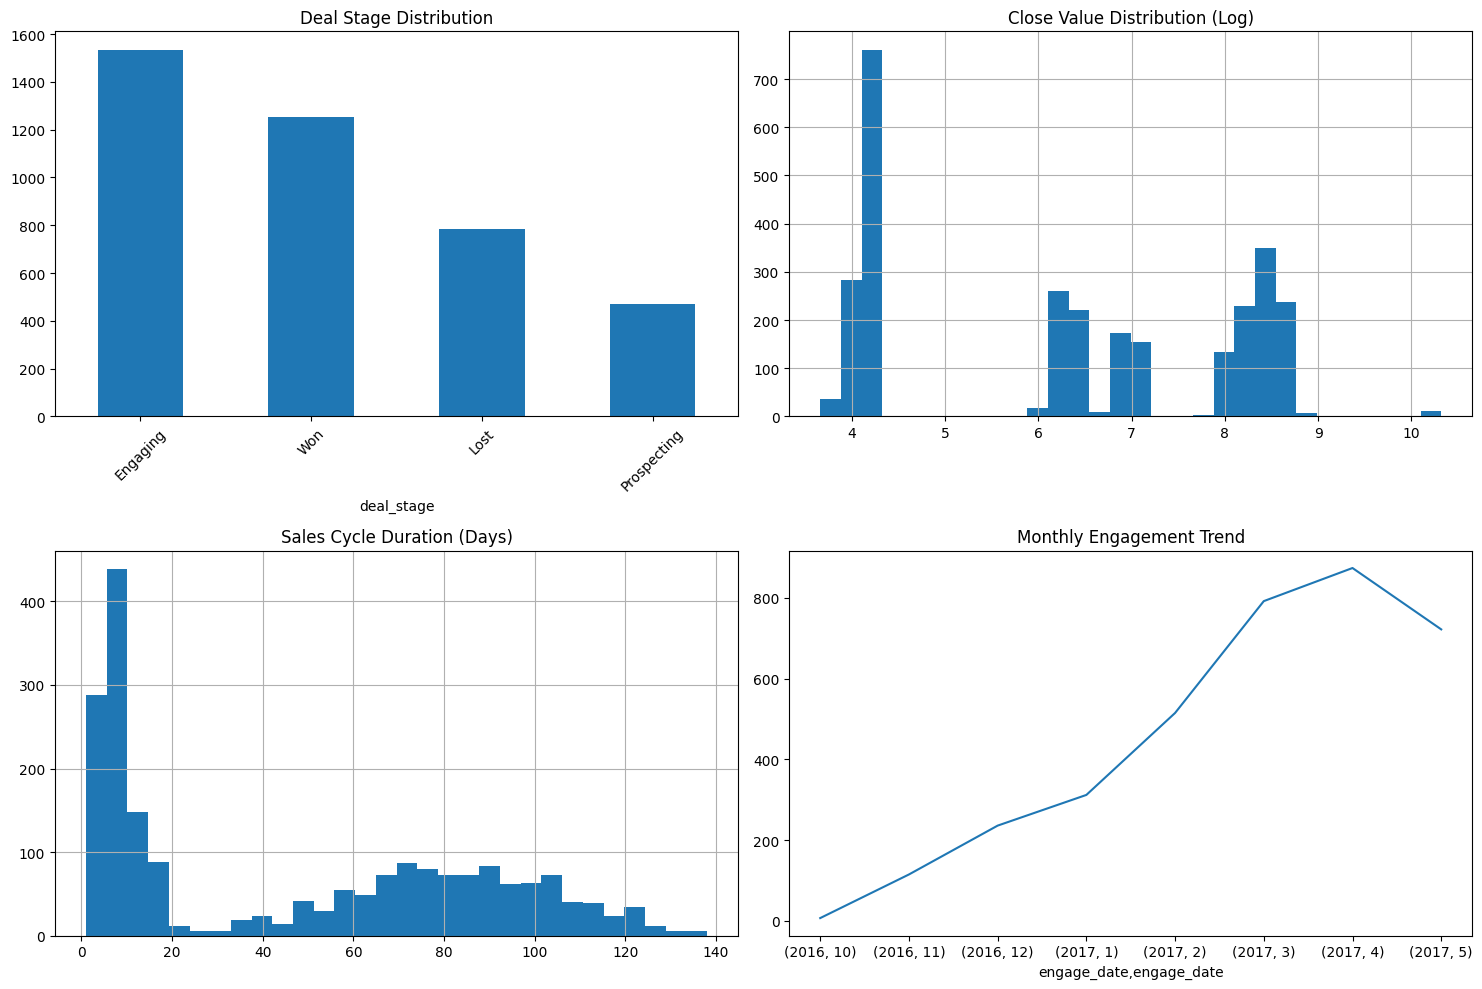

Data processing visualization completed!


In [291]:
# Quick visualization of key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Deal stage distribution
df_processed['deal_stage'].value_counts().plot(kind='bar', ax=axes[0,0], title='Deal Stage Distribution')
axes[0,0].tick_params(axis='x', rotation=45)

# Close value distribution (log scale)
df_processed[df_processed['close_value'] > 0]['close_value_log'].hist(bins=30, ax=axes[0,1] ).set_title('Close Value Distribution (Log)')

# Sales cycle duration
df_processed[df_processed['sales_cycle_days'].notna()]['sales_cycle_days'].hist(bins=30, ax=axes[1,0]).set_title('Sales Cycle Duration (Days)')

df_engaged = df_processed[df_processed['engage_date'].notna()]

# Monthly engagement trend
monthly_engagement = df_engaged.groupby([df_engaged['engage_date'].dt.year.astype(int), df_engaged['engage_date'].dt.month.astype(int)]).size()
monthly_engagement.plot(ax=axes[1,1], title='Monthly Engagement Trend')

plt.tight_layout()
plt.show()

print("Data processing visualization completed!")